In [5]:
import numpy as np
import pandas as pd
import os

from scipy import optimize
import sklearn.gaussian_process as skg
from scipy.special import erf, erfc
from sklearn.gaussian_process.kernels import RBF, ConstantKernel
import matplotlib.pyplot as plt

import bokeh.io 
from bokeh.plotting import figure, show
from bokeh.layouts import gridplot
from bokeh.transform import linear_cmap
from bokeh.models import LinearColorMapper
bokeh.io.output_notebook()

Loading BokehJS ...

---
# Setting up MATLAB link for simulations

In [2]:
eng = matlab.engine.start_matlab()
eng.cd('.', nargout=0)
eng.cd('../matlab', nargout=0)

In [166]:
obs_loc = matlab.double([[2],[0.1]])
goal = matlab.double([[4],[0]])
alpha = 0.2

out_SD = eng.single_vs_double_integrator(obs_loc, goal, alpha)
out_U = eng.unicycle(obs_loc,goal,alpha)
out = {**out_SD, **out_U}
for x in out.keys():
    out[x] = np.asarray(out[x])

In [168]:
p1 = figure(match_aspect=True,
           plot_width=400,
           plot_height=400)
# p1.line(
#     out["xU"][:,0],
#     out["xU"][:,1],
#     line_width=3,
#     color="blue",
#     legend_label="Unicycle"
# )
# p1.line(
#     out["xD"][:,0],
#     out["xD"][:,1],
#     line_width=3,
#     color="blue",
#     legend_label="Double Integrator"
# )
p1.line(
    out["xS"][:,0],
    out["xS"][:,1],
    line_width=3,
    color="green",
    # legend_label="Single Integrator"
)

p1.circle(
    obs_loc[0],
    obs_loc[1],
    radius=0.02,
    color="black"
)

p1.circle(
    obs_loc[0],
    obs_loc[1],
    radius=0.5,
    fill_alpha=0,
    line_width=3,
    color="black"
)

p2 = figure(
    x_axis_label="Time",
    y_axis_label="CBF"
)
# p2.line(
#     out["tU"][:,0],
#     out["hU"][:,0],
#     line_width=3,
#     color="blue"
# )
p2.line(
    out["tD"][:,0],
    out["hD"][:,0],
    line_width=3,
    color="blue"
)
p2.line(
    out["tS"][:,0],
    out["hS"][:,0],
    line_width=3,
    color="green"
)

p2.line(
    [0,60],
    [0,0],
    line_width=3,
    color="black"
)

p1.legend.location = "bottom_left"

grid = gridplot([[p1,p2]])
show(grid)

/home/kellan/anaconda3/lib/python3.9/site-packages/bokeh/models/plots.py:815: UserWarning: 
You are attempting to set `plot.legend.location` on a plot that has zero legends added, this will have no effect.

Before legend properties can be set, you must add a Legend explicitly, or call a glyph method with a legend parameter set.

  warnings.warn(_LEGEND_EMPTY_WARNING % attr)


In [5]:
np.min(out["hU"])

0.05208148401003211

---
# Initialize GPA and define visualization function

In [6]:
lam = 1e-2
l = 0.5
kernel = ConstantKernel(1.0, constant_value_bounds="fixed") * RBF(l, length_scale_bounds="fixed")
gpa = skg.GaussianProcessRegressor(
    alpha=lam,
    kernel=kernel
)

In [7]:
def norm_error(out):
    
    outS = np.array(out["xS"])
    outD = np.array(out["xD"])
    
    xS = outS[:,0]
    yS = outS[:,1]
    xD = outD[:,0]
    yD = outD[:,1]
    
    err = np.sqrt((xS-xD)**2 + (yS-yD)**2)
    
#     p = figure(match_aspect=False)
#     p.line(np.arange(len(xS)),xS)
#     p.line(np.arange(len(xS)),xD,color="red")
    
#     p.line(xS,yS)
#     p.line(xD,yD,color="red")
#     show(p)
    
    return err

In [8]:
def h_error(out):
    
    hS = np.array(out["hS"])
    hD = np.array(out["hD"])
    
    err = hS-hD
    
    return err

In [9]:
def query_di(x,a=0.5):

    # print(x)
    obs_loc = matlab.double([[x[0]],[x[1]]])
    goal = matlab.double([[4],[0]])
    out_SD = eng.single_vs_double_integrator(obs_loc, goal, float(a))
    
    return 0.1+np.min(h_error(out_SD))
    # return np.min(out_SD["hD"])

In [10]:
out = query_di([1,2])
print(out)

-0.014657559275079807


In [11]:
%%capture
n0 = 100
x0 = np.random.uniform(0,2,(n0,1))
y0 = np.random.uniform(-0.5,0.5,(n0,1))

X = np.hstack((x0,y0))
y = np.array([query_di(x.tolist()) for x in X]).reshape(-1,1)
gpa.fit(X,y)

In [158]:
def viz_gpa(gpa,thresh=False, contour=False, return_contour=False, return_thresh=False, return_cont=False):

    x1range = [0,2]
    x2range = [-0.5,0.5]
    dx = 0.0025
    alpha = 0.5

    nx1 = int(np.diff(x1range)[0]/dx)
    nx2 = int(np.diff(x2range)[0]/dx)
    
    p = figure(
        x_range=[0,2],
        y_range=[-0.5,0.5],
        match_aspect=True,
        plot_width=600,
        plot_height=600*nx2//nx1,
    )

    X1grid,X2grid = np.meshgrid(np.arange(*x1range,dx),np.arange(*x2range,dx))
    Xs = np.vstack([X1grid.ravel(), X2grid.ravel()]).transpose()
    # Xs = np.hstack((Xs, np.ones((Xs.shape[0],1))*alpha))

    # print(Xs)

    ys = gpa.predict(Xs).flatten()

    ys = ys.reshape(nx2,nx1)

    # print(ys)

    color_mapper = LinearColorMapper(palette='Viridis256', low=-1, high=1)

    if thresh:
        p.image(
            image=[(ys>0).astype(int)],
            x=x1range[0],
            y=x2range[0],
            dw=np.diff(x1range)[0],
            dh=np.diff(x2range)[0],
            color_mapper = color_mapper
        )
    else:
        p.image(
            image=[-ys],
            x=x1range[0],
            y=x2range[0],
            dw=np.diff(x1range)[0],
            dh=np.diff(x2range)[0],
            palette='Viridis256'
        )
    if contour:
        plt.ioff()
        c = plt.contour(ys,[0])
        contsegs = c.allsegs[0][0]
        p.line(
            x=contsegs[:,0]*dx+x1range[0],
            y=contsegs[:,1]*dx+x2range[0],
            line_width=3,
            color="black"
        )
        # print(contour)
    
    if contour and return_contour:
        return [contsegs[:,0]*dx+x1range[0], contsegs[:,1]*dx+x2range[0]]
    elif return_thresh:
        return (ys>0).astype(int)
    elif return_cont:
        return ys
    else:
        return p

# Ground Truth (Uniform Random, N=2000)

In [13]:
gpa_gt=skg.GaussianProcessRegressor(
    alpha=lam,
    kernel=kernel
)

n0 = 2000
x0 = np.random.uniform(0,2,(n0,1))
y0 = np.random.uniform(-0.5,0.5,(n0,1))

X = np.hstack((x0,y0))
y = np.array([query_di(x.tolist()) for x in X]).reshape(-1,1)
# print(y)
gpa_gt.fit(X,y)

GaussianProcessRegressor(alpha=0.01, kernel=1**2 * RBF(length_scale=0.5))

In [14]:
#Radial Sampling
gpa_gt=skg.GaussianProcessRegressor(
    alpha=lam,
    kernel=kernel
)

n0 = 900
r0 = np.random.uniform(0.25,0.5,(n0,1))
t0 = np.random.uniform(0,2*np.pi,(n0,1))
x0 = r0*np.cos(t0)+0.5
y0 = r0*np.sin(t0)

n1 = 100
x1 = np.random.uniform(0,2,(n1,1))
y1 = np.random.uniform(-0.5,0.5,(n1,1))

x0 = np.vstack((x0,x1))
y0 = np.vstack((y0,y1))

# x0 = np.random.uniform(0,2,(n0,1))
# y0 = np.random.uniform(-0.5,0.5,(n0,1))

X = np.hstack((x0,y0))
y = np.array([query_di(x.tolist()) for x in X]).reshape(-1,1)
# print(y)
gpa_gt.fit(X,y)

GaussianProcessRegressor(alpha=0.01, kernel=1**2 * RBF(length_scale=0.5))

In [15]:
plt.ioff()
p=viz_gpa(gpa_gt,thresh=False, contour=True)
p.circle(
    gpa_gt.X_train_[:,0],
    gpa_gt.X_train_[:,1],
    color="black"
)

show(p)

In [16]:
c_gt = viz_gpa(gpa_gt,thresh=False, contour=True, return_contour=True)

# Uniform Random, N=100

In [17]:
gpa_ur=skg.GaussianProcessRegressor(
    alpha=lam,
    kernel=kernel
)

n0 = 100
x0 = np.random.uniform(0,2,(n0,1))
y0 = np.random.uniform(-0.5,0.5,(n0,1))

X = np.hstack((x0,y0))
y = np.array([query_di(x.tolist()) for x in X]).reshape(-1,1)
# print(y)
gpa_ur.fit(X,y)

GaussianProcessRegressor(alpha=0.01, kernel=1**2 * RBF(length_scale=0.5))

In [18]:
p=viz_gpa(gpa_ur,thresh=False, contour=True)
p.circle(
    gpa_ur.X_train_[:,0],
    gpa_ur.X_train_[:,1],
    color="black"
)

show(p)

# Grid Search, N=100

In [19]:
gpa_gs=skg.GaussianProcessRegressor(
    alpha=lam,
    kernel=kernel
)

n0 = 100
nx = 10
ny = 10

xx = np.arange(0,2,2/nx)+1/nx
yy = np.arange(0,1,1/nx)-0.5+0.5/ny

x0,y0=np.meshgrid(xx,yy)
x0=x0.reshape([-1,1])
y0=y0.reshape([-1,1])


# x0 = np.random.uniform(0,2,(n0,1))
# y0 = np.random.uniform(-0.5,0.5,(n0,1))

X = np.hstack((x0,y0))
y = np.array([query_di(x.tolist()) for x in X]).reshape(-1,1)
# print(y)
gpa_gs.fit(X,y)

GaussianProcessRegressor(alpha=0.01, kernel=1**2 * RBF(length_scale=0.5))

In [20]:
p=viz_gpa(gpa_gs,thresh=False, contour=True)
p.circle(
    gpa_gs.X_train_[:,0],
    gpa_gs.X_train_[:,1],
    color="black"
)

show(p)

In [21]:
x1range = [0,2]
x2range = [-0.5,0.5]
dx = 0.01
alpha = 0.5

nx1 = int(np.diff(x1range)[0]/dx)
nx2 = int(np.diff(x2range)[0]/dx)

X1grid,X2grid = np.meshgrid(np.arange(*x1range,dx),np.arange(*x2range,dx))
Xs = np.vstack([X1grid.ravel(), X2grid.ravel()]).transpose()
# Xs = np.hstack((Xs, np.ones((Xs.shape[0],1))*alpha))

# print(Xs)

ys = gpa.predict(Xs).flatten()

ys = ys.reshape(nx2,nx1)

c = plt.contour(ys,[0])
contour = c.allsegs[0][0]

In [22]:
c_gs = viz_gpa(gpa_gs,thresh=False, contour=True, return_contour=True)

In [23]:
p = figure(
    x_range=[0,2],
    y_range=[-0.5,0.5],
    match_aspect=True,
    plot_width=600,
    plot_height=300
)
p.line(
    x=c_gt[0],
    y=c_gt[1],
    line_width=3,
    color='red'
)
p.line(
    x=c_gs[0],
    y=c_gs[1]
)
show(p)

In [113]:
def solve_gs(n_samples):
    
    gpa_gs=skg.GaussianProcessRegressor(
        alpha=lam,
        kernel=kernel
    )

    n0 = n_samples
    nn = int(np.sqrt(n0))

    xx = np.arange(0,2,2/nn)+1/nn
    yy = np.arange(0,1,1/nn)-0.5+0.5/nn

    x0,y0=np.meshgrid(xx,yy)
    x0=x0.reshape([-1,1])
    y0=y0.reshape([-1,1])

    # x0 = np.random.uniform(-1,1,(n0,1))
    # y0 = np.random.uniform(-1,1,(n0,1))

    X = np.hstack((x0,y0))
    print(X.shape)
    y = np.array([query_di(x.tolist()) for x in X]).reshape(-1,1)
    # print(y)
    gpa_gs.fit(X,y)
    
    regret = np.sum(np.abs(viz_gpa(gpa_gs,return_thresh=True)-viz_gpa(gpa_gt2,return_thresh=True)))/NN
    
    return regret

In [115]:
err_gs=[]
for i in tqdm(np.arange(3,11)):
    err_gs.append(solve_gs(i**2))

  0%|                                                     | 0/8 [00:00<?, ?it/s]

(9, 2)


 12%|█████▋                                       | 1/8 [00:02<00:19,  2.80s/it]

(16, 2)


 25%|███████████▎                                 | 2/8 [00:06<00:19,  3.23s/it]

(25, 2)


 38%|████████████████▉                            | 3/8 [00:10<00:18,  3.74s/it]

(36, 2)


 50%|██████████████████████▌                      | 4/8 [00:16<00:17,  4.40s/it]

(49, 2)


 62%|████████████████████████████▏                | 5/8 [00:22<00:15,  5.23s/it]

(64, 2)


 75%|█████████████████████████████████▊           | 6/8 [00:30<00:12,  6.16s/it]

(81, 2)


 88%|███████████████████████████████████████▍     | 7/8 [00:40<00:07,  7.36s/it]

(100, 2)


100%|█████████████████████████████████████████████| 8/8 [00:52<00:00,  6.51s/it]


---
# Set up sampling method

In [24]:
def gpa_next(gpa,x,y):

    n = gpa.X_train_.shape[1]
    g = skg.GaussianProcessRegressor(
        alpha=1e-6,
        kernel=kernel
    )
    g.fit(
        np.vstack((gpa.X_train_, np.array(x).reshape(-1,n))),
        np.vstack((gpa.y_train_, np.array(y).reshape(-1,1)))
    )
    # print(g.X_train_)
    return g

In [25]:
def p_err(mu,sig):
    return 0.5 - erf(np.abs(mu)/(np.sqrt(2)*sig))

In [26]:
# Given a pair (x,y) of "next" data, return the posterior intagrated Perr
def p_err_next(gpa,x,y):
    
    g = gpa_next(gpa,[x],y)
    
    x1range=[0,2] # x position
    x2range=[-0.5,0.5] # y position
    dx = 0.05

    nx1 = int(np.diff(x1range)[0]/dx)
    nx2 = int(np.diff(x2range)[0]/dx)

    X1grid,X2grid = np.meshgrid(np.arange(*x1range,dx),np.arange(*x2range,dx))
    Xs = np.vstack([X1grid.ravel(), X2grid.ravel()]).transpose()

    mus, stds = g.predict(Xs, return_std=True)
    mus = mus[:,0]
    p_err_tp1 = np.sum(p_err(mus,stds))
    
    return p_err_tp1

In [27]:
# Given only a "next" x, assume the sampled y will land exactly on the mean and then return the posterior Perr
@jit
def infer_next(x,args):
    
    gpa = args
    
    n = gpa.X_train_.shape[1]
    yi = gpa.predict(x.reshape(-1,n))
    
    p_err_inf = p_err_next(gpa,x,yi)
    
    return p_err_inf

In [28]:
p_err_next(gpa,np.array([2,0]),0.5)

-3.917191361508554e+02

In [29]:
bounds = [
    [0,2],
    [-0.5,0.5]
]

opt = optimize.differential_evolution(
    infer_next,
    bounds,
    args=[gpa]
)
opt.x

/tmp/ipykernel_3613/3791675807.py:2: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "infer_next" failed type inference due to: Untyped global name 'p_err_next': Cannot determine Numba type of <class 'function'>

File "../../../../../tmp/ipykernel_3613/3791675807.py", line 10:
<source missing, REPL/exec in use?>

  @jit
/home/kellan/anaconda3/lib/python3.9/site-packages/numba/core/object_mode_passes.py:151: NumbaWarning: Function "infer_next" was compiled in object mode without forceobj=True.

File "../../../../../tmp/ipykernel_3613/3791675807.py", line 2:
<source missing, REPL/exec in use?>

  warnings.warn(errors.NumbaWarning(warn_msg,
/home/kellan/anaconda3/lib/python3.9/site-packages/numba/core/object_mode_passes.py:161: NumbaDeprecationWarning: 
Fall-back from the nopython compilation path to the object mode compilation path has been detected, this is deprecated behaviour.

For more information visit https://numba.readthedocs.io/

array([ 0.14847923, -0.32850753])

# Max Error Reduction (N=100)

In [7]:
lam = 1e-2
l = 0.5
kernel = ConstantKernel(1.0, constant_value_bounds="fixed") * RBF(l, length_scale_bounds="fixed")

err_di=[]
for i in range(5):
    
    gpa_di = skg.GaussianProcessRegressor(
        alpha=lam,
        kernel=kernel
    )

    # Generate random initial data
    n0 = 5
    x0 = np.random.uniform(0,2,(n0,1))
    y0 = np.random.uniform(-0.5,0.5,(n0,1))

    X = np.hstack((x0,y0))
    print(X)
    y = np.array([query_di(x.tolist()) for x in X]).reshape(-1,1)
    gpa_di.fit(X,y)

    print(X)
    print(y)
    
    bounds = [
        [0,2],
        [-0.5,0.5]
    ]

    N = 95

    err_di.append([])
    for i in tqdm(range(N)):

        opt = optimize.differential_evolution(
            infer_next,
            bounds,
            args=[gpa_di]
        )

        # opt = optimize.basinhopping(
        #     infer_next,
        #     [1,0,0.5],

        x_next = opt.x
        # print(x_next)
        # x_next=[np.random.uniform(0,2),np.random.uniform(-0.5,0.5)]

        # print(x_next[2])
        y_next = query_di(x_next)

        gpa_di = gpa_next(gpa_di,x_next,y_next)

        if np.sqrt(i)%1==0:
            err_di[-1].append(np.sum(np.abs(viz_gpa(gpa_di,return_thresh=True)-viz_gpa(gpa_gt2,return_thresh=True))))
        # regret_di.append(regret)

        # p = viz_gpa(gpa,[0,2],[-0.5,0.5],0.01,0.5,thresh=True)
        # show(p)

[[ 0.69141111 -0.3538059 ]
 [ 1.8731436  -0.36078747]
 [ 0.48690047 -0.3858419 ]
 [ 1.28395586 -0.14471758]
 [ 1.5189957  -0.13697946]]


NameError: name 'query_di' is not defined

In [140]:
c_di = viz_gpa(gpa_di,thresh=False, contour=True, return_contour=True)

In [143]:
p = figure(
    x_range=[0,2],
    y_range=[-0.5,0.5],
    match_aspect=True,
    plot_width=600,
    plot_height=300
)

p.line(
    x=c_di[0],
    y=c_di[1],
    line_width=3
)
p.circle(
    gpa_di.X_train_[:,0],
    gpa_di.X_train_[:,1],
    radius=0.008,
)

show(p)

In [191]:
thr_di = 1-viz_gpa(gpa_di,return_thresh=True)
thr_gt2 = 1-viz_gpa(gpa_gt2,return_thresh=True)
cont_di = -viz_gpa(gpa_di,return_cont=True)
cont_gt2 = -viz_gpa(gpa_gt2,return_cont=True)

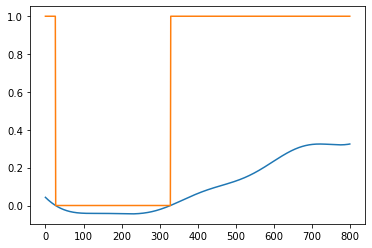

In [192]:
plt.plot(cont_di[200,:])
plt.plot(thr_di[200,:])
plt.show()

In [194]:
np.mean(cont_di[np.bitwise_and(thr_di.astype(bool), (1-thr_gt2).astype(bool))])

0.00387501677985466

In [189]:
np.sum(np.bitwise_and(thr_di, thr_gt2))/NN

-0.187746875

In [128]:
err_di = np.array(err_di)

In [129]:
NN = np.product(viz_gpa(gpa_gt2,return_thresh=True).shape)
mu = np.mean(err_di,axis=0)/NN
sig = np.std(err_di,axis=0)/NN

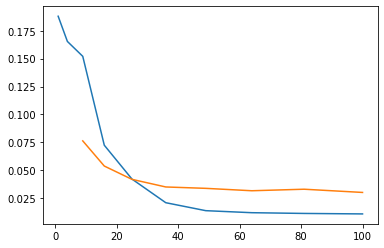

In [130]:
plt.plot(np.arange(1,11)**2,mu)
plt.plot(np.arange(3,11)**2,err_gs)
plt.show()

In [133]:
p = figure(
    x_range=[10,100],
    y_range=[0.001,0.5],
    y_axis_type="log",
    plot_width=400,
    plot_height=300,
    x_axis_label="Number of Samples",
    y_axis_label="Error Rate"
)

x1=np.arange(1,11)**2
x2=x1[::-1]
y1=mu+sig
y2=(mu-sig)[::-1]
x = np.hstack((x1, x2))
y = np.hstack((y1, y2))

p.line(
    x=x1,
    y=mu,
    line_width=3,
    legend_label="Uncertainty Minimization"
)

p.line(
    x=np.arange(3,11)**2,
    y=err_gs,
    color='red',
    line_width=3,
    legend_label="Grid Search"
)

p.patch(
    x=x,
    y=y,
    alpha=0.5
)

show(p)

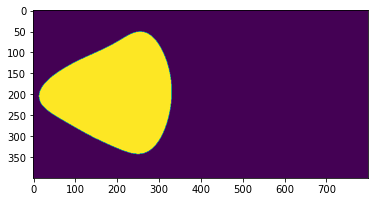

3.2e+01

In [135]:
plt.imshow(viz_gpa(gpa_gt2,return_thresh=True))
plt.show()
NN/1e4

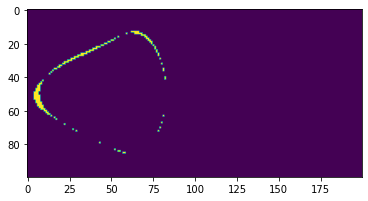

300

In [71]:
plt.imshow(np.abs(viz_gpa(gpa_di,return_thresh=True)-viz_gpa(gpa_gt2,return_thresh=True)))
plt.show()
NN

In [32]:
N=(2/.01)*(1/.01)

In [33]:
# plt.plot(np.array(regret_di)/N)
# plt.plot(np.array(regret_di1)/N)
# plt.legend(["Uniform Random","Uncertainty Minimization"])
# plt.xlabel("Iterations")
# plt.ylabel("Classification Error")
# plt.savefig("error.png")
# plt.show()

In [34]:
p = viz_gpa(gpa_di,thresh=False, contour=True)
p.circle(
    gpa_di.X_train_[5:,0],
    gpa_di.X_train_[5:,1],
    color="black"
)
show(p)

# Max Error Reduction (N=500)

In [41]:
lam = 1e-2
l = 0.5
kernel = ConstantKernel(1.0, constant_value_bounds="fixed") * RBF(l, length_scale_bounds="fixed")
gpa_gt2 = skg.GaussianProcessRegressor(
    alpha=lam,
    kernel=kernel
)

# Generate random initial data
n0 = 10
x0 = np.random.uniform(0,2,(n0,1))
y0 = np.random.uniform(-0.5,0.5,(n0,1))

X = np.hstack((x0,y0))
y = np.array([query_di(x.tolist()) for x in X]).reshape(-1,1)
gpa_gt2.fit(X,y)

bounds = [
    [0,2],
    [-0.5,0.5]
]

N = 500
for i in tqdm(range(N)):
    
    opt = optimize.differential_evolution(
        infer_next,
        bounds,
        args=[gpa_gt2]
    )
    
    # opt = optimize.basinhopping(
    #     infer_next,
    #     [1,0,0.5],
        
    x_next = opt.x
    # print(x_next[2])
    y_next = query_di(x_next)
    
    gpa_gt2 = gpa_next(gpa_gt2,x_next,y_next)
    
    # p = viz_gpa(gpa,[0,2],[-0.5,0.5],0.01,0.5,thresh=True)
    # show(p)

100%|█████████████████████████████████████████| 500/500 [05:59<00:00,  1.39it/s]


In [139]:
p = viz_gpa(gpa_gt,thresh=False, contour=True)
show(p)

In [42]:
c_gt2 = viz_gpa(gpa_gt2,thresh=False, contour=True, return_contour=True)
c_gs = viz_gpa(gpa_gs,thresh=False, contour=True, return_contour=True)
c_di = viz_gpa(gpa_di,thresh=False, contour=True, return_contour=True)

In [121]:
p = figure(
    x_range=[0,2],
    y_range=[-0.5,0.5],
    match_aspect=True,
    plot_width=600,
    plot_height=300
)

p.line(
    x=c_gt2[0],
    y=c_gt2[1],
    line_width=3,
    color='red',
    legend_label="Ground Truth (N=2000)"
)
p.line(
    x=c_gs[0],
    y=c_gs[1],
    line_width=3,
    color='blue',
    legend_label="Grid Search (N=100)"
)
# p.circle(
#     gpa_gs.X_train_[:,0],
#     gpa_gs.X_train_[:,1],
#     radius=0.005,
#     color="blue"
# )

p.line(
    x=c_di[0],
    y=c_di[1],
    line_width=3,
    color='green',
    legend_label="Uncertainty Minimization (N=100)"
)
p.circle(
    gpa_di.X_train_[10:,0],
    gpa_di.X_train_[10:,1],
    radius=0.008,
    color="green"
)
show(p)

In [118]:
def save_data(gpa, fname):
    
    x1range=[0,2] # x position
    x2range=[-0.5,0.5] # y position
    x3range=[0.1,1] # alpha
    dx=0.05
    
    nx1 = int(np.diff(x1range)[0]/dx)
    nx2 = int(np.diff(x2range)[0]/dx)

    X1grid,X2grid,X3grid = np.meshgrid(np.arange(*x1range,dx),np.arange(*x2range,dx),np.arange(*x3range,dx))
    Xs = np.vstack([X1grid.ravel(), X2grid.ravel(), X3grid.ravel()]).transpose()

    mus,stds = gpa.predict(Xs, return_std=True)
    mus = mus.flatten()

    data = np.hstack((Xs,mus.reshape(-1,1),stds.reshape(-1,1)))
    df = pd.DataFrame(
        data=data,
        columns=["x1","x2","alpha","mean","stdev"]
    )
    
    df.to_csv(fname)

In [40]:
save_data(gpa_di,"gridplot_di.csv")
save_data(gpa_uni,"gridplot_uni.csv")

ValueError: X has 3 features, but GaussianProcessRegressor is expecting 2 features as input.